In [8]:
root='/kaggle/working/'
import sys
!git clone https://github.com/nudojacopo/thesis.git
module_path = root+'thesis/src/SYN/SYN_package'
sys.path.append(module_path)
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
!pip install powerlaw
from functions import *
from estimate_parameters import *
import json
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import powerlaw
import warnings
!pip install gdown
import gdown

url='https://drive.google.com/uc?id=1LUaN2XL3o9TIggKTxcNkmIGSdBx01Hqo'
output='facebook.csv'
gdown.download(url,output,quiet=False)

url='https://drive.google.com/uc?id=1Dq5Z8KjEhbiUNTd8vgxX0ZK6aP_a7h4I'
output='voat.csv'
gdown.download(url,output,quiet=False)

url='https://drive.google.com/uc?id=1jXcIGv2zoTZeuj8W2EPXyhQLOaiRU2Tn'
output='gab.csv'
gdown.download(url,output,quiet=False)

url='https://drive.google.com/uc?id=1qCPKDWjl9CxaRf8EJK5oFGvwae0xC9-q'
output='reddit.csv'
gdown.download(url,output,quiet=False)

fatal: destination path 'thesis' already exists and is not an empty directory.
^C
ERROR: Operation cancelled by user


Exception ignored in: <function tqdm.__del__ at 0x7c8d1d90cf70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/tqdm/std.py", line 1147, in __del__
    def __del__(self):
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
fb=pd.read_csv('/kaggle/working/facebook.csv')
rd=pd.read_csv('/kaggle/working/reddit.csv')
vo=pd.read_csv('/kaggle/working/voat.csv')
gb=pd.read_csv('/kaggle/working/gab.csv')

h=100
n=1000000

In [ ]:
fb=filter_first_h(fb,h)

gb=filter_first_h(gb,h)

rd=filter_first_h(rd,h)

vo=filter_first_h(vo,h)

names = ['gb','rd','fb','vo']
datas = [gb,rd,fb,vo]

params_dict = process_social_platform(names, datas)

In [37]:
time_intervals = np.arange(0, 1, 0.02)
n=5000

all_dfs = []
for i, df in enumerate(datas):
    social = names[i]
    parameters = params_dict[social]

    simulated_t, observed_t = simulate_data(df, parameters, activate_tqdm=True, num_threads=n)# peensaree a come limitar i valori dell funzionee IAT senza crear break infiniti
    globals()[f"{social}s_M1"] = simulated_t
    globals()[f"{social}o_M1"] = observed_t
    df_simulated = pd.DataFrame(simulated_t, columns=[f"{social}s_M1_col{i}" for i in range(simulated_t.shape[1])])
    df_observed = pd.DataFrame(observed_t, columns=[f"{social}o_M1_col{i}" for i in range(observed_t.shape[1])])

    df_simulated.to_csv(f"{social}s_M1.csv", index=False)
    df_observed.to_csv(f"{social}o_M1.csv", index=False)

    simulated_t_ECDF = calculate_ECDF(simulated_t, time_intervals)
    simulated_t_ECDF['Platform'] = social
    simulated_t_ECDF['Style'] = 'Simulated'

    observed_t_ECDF = calculate_ECDF(observed_t, time_intervals)
    observed_t_ECDF['Platform'] = social
    observed_t_ECDF['Style'] = 'Observed'

    df_platform = pd.concat([simulated_t_ECDF, observed_t_ECDF], ignore_index=True)
    all_dfs.append(df_platform)

df_all_M1 = pd.concat(all_dfs, ignore_index=True)


Processing DataFrame: 100%|██████████| 5000/5000 [03:48<00:00, 21.91it/s]


Dynamics

In [58]:
df_all_M1['Time Grid Value']=df_all_M1['Time Grid Value']*100

In [59]:
df_all_M1['Time Grid Value']

0          0.00
1          0.02
2          0.04
3          0.06
4          0.08
           ... 
1999995    0.90
1999996    0.92
1999997    0.94
1999998    0.96
1999999    0.98
Name: Time Grid Value, Length: 2000000, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


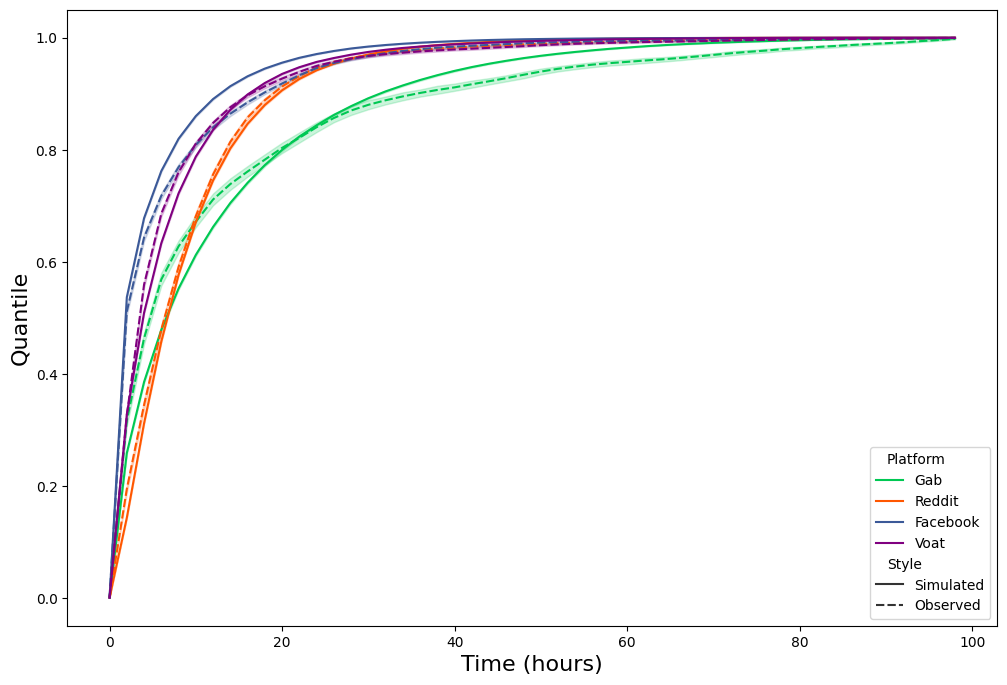

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming df_all_M1 is your DataFrame
# df_all_M1 = pd.read_csv('your_data.csv')

# Sort the DataFrame by 'Style'
df_all = df_all_M1.sort_values(by='Style')
df_all_M1['Time Grid Value']=df_all_M1['Time Grid Value']*100
# Define specific colors for each platform
colors = {
    'Reddit': '#FF5700',
    'Voat': '#800080',
    'Facebook': '#3b5998',
    'Gab': '#00c853'
}

dictionary= {
    'rd': 'Reddit',
    'vo': 'Voat',
    'fb': 'Facebook',
    'gb': 'Gab'
}
df_all_M1['Platform'] = df_all_M1['Platform'].replace(dictionary)


# Plot comment arrival dynamic
plt.figure(figsize=(12, 8))
df_all_M1['Platform']
sns.lineplot(data=df_all_M1, x='Time Grid Value', y='Share', hue='Platform', style='Style',
             err_style='band',errorbar=('ci', 99), palette=colors)
plt.ylabel('Quantile', fontsize=16)
plt.xlabel('Time (hours)', fontsize=16)
plt.grid(False)


# Show the plot
plt.show()


In [63]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_all_M1 is your DataFrame containing Simulate and Observed data
# Sort the DataFrame by 'Style' (if necessary)
df_all = df_all_M1.sort_values(by='Style')

# Define a dictionary to map abbreviations to full platform names
dictionary = {
    'rd': 'Reddit',
    'vo': 'Voat',
    'fb': 'Facebook',
    'gb': 'Gab'
}
df_all_M1['Platform'] = df_all_M1['Platform'].replace(dictionary)

# Assuming 'Simulate' and 'Observed' columns are already calculated or available in df_all_M1

# Loop through each platform to perform KS test and plot the results
platforms = df_all_M1['Platform'].unique()

for platform in platforms:
    # Extract Simulate and Observed data for the current platform
    data_simulate = df_all_M1[df_all_M1['Platform'] == platform]['Simulated']
    data_observed = df_all_M1[df_all_M1['Platform'] == platform]['Observed']
    
    # Perform KS test
    ks_statistic, p_value = stats.ks_2samp(data_simulate, data_observed)
    
    # Print KS test results
    print(f"KS Test for {platform}: Statistic={ks_statistic:.4f}, p-value={p_value:.4f}")
    
    # Plot Simulate vs Observed for the current platform
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data_simulate, label='Simulated', color='blue', shade=True)
    sns.kdeplot(data_observed, label='Observed', color='orange', shade=True)
    plt.title(f'Simulate vs Observed for {platform}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()


KeyError: 'Simulated'

In [77]:
observed=df_all_M1[(df_all_M1['Style']=='Observed') &  (df_all_M1['Platform']=='Facebook')]['Share']
simulated=df_all_M1[(df_all_M1['Style']=='Simulated') &  (df_all_M1['Platform']=='Facebook')]['Share']


Participation

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # tqdm for progress bar

# Assuming rd, fb, vo, yt are your DataFrames

# Add 'platform' column to each DataFrame
rdo_M1['platform'] = 'Reddit'
voo_M1['platform'] = 'Voat'
fbo_M1['platform'] = 'Facebook'
gbo_M1['platform'] = 'Gab'
# Combine all DataFrames into a single DataFrame
all_data = []

# Process each dataset individually
for df in tqdm([rdo_M1,  voo_M1,fbo_M1,gbo_M1]):#yto
    df['number_of_comments'] = df.groupby('post_id')['post_id'].transform('count')
    df['sequential_position'] = df.groupby('post_id')['temporal_distance_birth_base_100h'].rank(method='first')

    # Determine the number of bins
    num_bins = 20

    # Calculate the bin of position
    df['bin_of_position'] = ((df['sequential_position'] - 1) / df['number_of_comments'] * num_bins).astype(int) + 1
    df['first_comment']=df['sequential_number_of_comment_by_user_in_thread']==1
    # Group by 'bin_of_position', 'post_id', and calculate unique users per post
    df['first_comment'] = df.groupby(['bin_of_position', 'post_id'])['first_comment'].transform('mean')
    all_data.append(df)
all_data = pd.concat(all_data, ignore_index=True)
# Aggregate data across all datasets
agg_activity_obs = all_data.groupby(['platform', 'bin_of_position', 'post_id'])['first_comment'].mean().reset_index()

100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # tqdm for progress bar

# Assuming rd, fb, vo, yt are your DataFrames

# Add 'platform' column to each DataFrame
rds_M1['platform'] = 'Reddit'
vos_M1['platform'] = 'Voat'
fbs_M1['platform'] = 'Facebook'
gbs_M1['platform'] = 'Gab'
# Combine all DataFrames into a single DataFrame
all_data = []

# Process each dataset individually
for df in tqdm([rds_M1,  vos_M1,fbs_M1,gbs_M1]):#yto
    df['number_of_comments'] = df.groupby('post_id')['post_id'].transform('count')
    df['sequential_position'] = df.groupby('post_id')['temporal_distance_birth_base_100h'].rank(method='first')

    # Determine the number of bins
    num_bins = 20

    # Calculate the bin of position
    df['bin_of_position'] = ((df['sequential_position'] - 1) / df['number_of_comments'] * num_bins).astype(int) + 1

    df['first_comment']=df['sequential_number_of_comment_by_user_in_thread']==1
    # Group by 'bin_of_position', 'post_id', and calculate unique users per post
    df['first_comment'] = df.groupby(['bin_of_position', 'post_id'])['first_comment'].transform('mean')
    all_data.append(df)
all_data = pd.concat(all_data, ignore_index=True)
# Aggregate data across all datasets
agg_activity_sim_M1 = all_data.groupby(['platform', 'bin_of_position', 'post_id'])['first_comment'].mean().reset_index()




100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

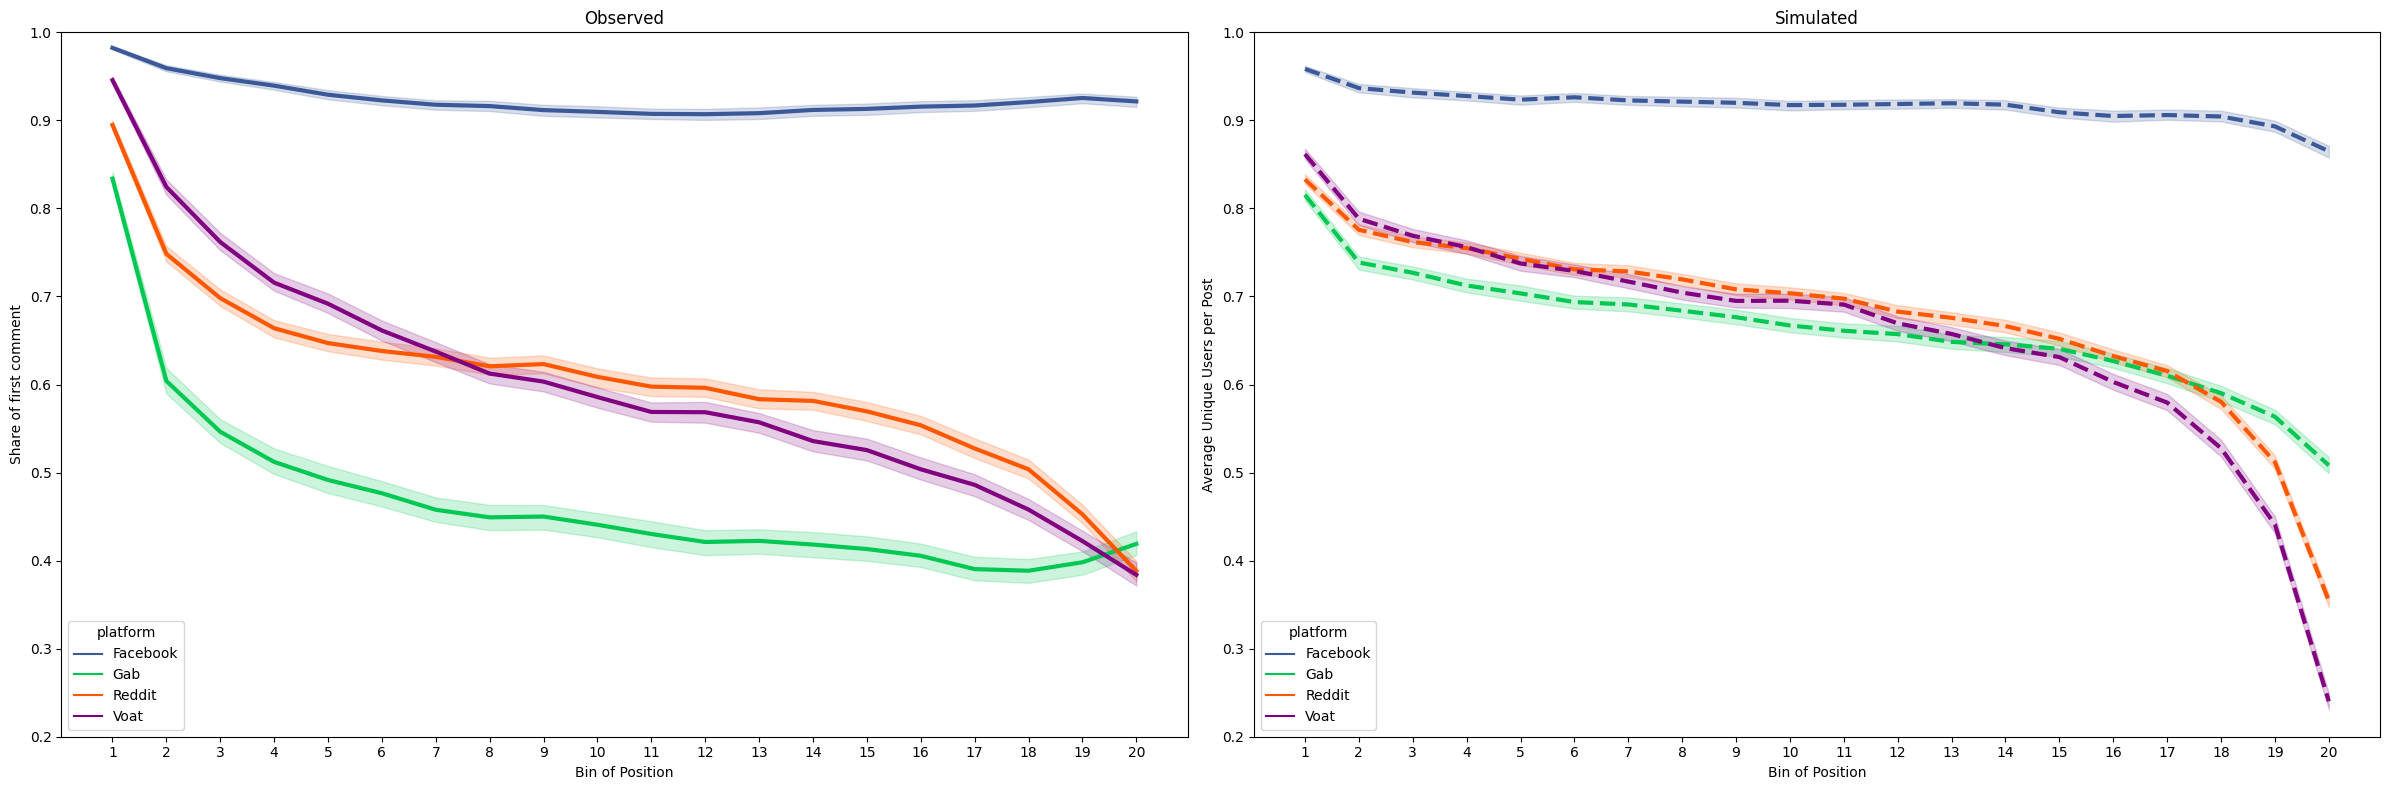

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define custom colors
colors = {
    'Reddit': '#FF5700',
    'Voat': '#800080',
    'Facebook': '#3b5998',
    'Gab': '#00c853'
}

# Assuming you have already defined agg_activity_sim_M1 and agg_activity_obs dataframes

# Setting up the figure with subplots
plt.figure(figsize=(24, 8))  # Adjust the figure size as needed

# Convert bin_of_position to integer
agg_activity_sim_M1['bin_of_position'] = agg_activity_sim_M1['bin_of_position'].astype(int)
agg_activity_obs['bin_of_position'] = agg_activity_obs['bin_of_position'].astype(int)

# Subplot for the first plot (agg_activity_sim_M1)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, first plot
sns.lineplot(
    data=agg_activity_sim_M1,
    x='bin_of_position',
    y='first_comment',
    hue='platform',  # Different line for each platform
    estimator='mean',  # Aggregation preference
    errorbar=('ci', 99),  # 80% confidence interval
    linewidth=3,
    palette=colors  # Use custom colors defined in the dictionary
)
plt.title('Simulated')
plt.ylabel('Average Unique Users per Post')
plt.xlabel('Bin of Position')
plt.grid(False)

# Set y-axis limits
plt.ylim(0.2, 1)

# Set x-axis ticks as integers
plt.xticks(agg_activity_sim_M1['bin_of_position'].unique())

# Manually setting the line style for one of the platforms
lines = plt.gca().get_lines()
for line in lines:
    line.set_linestyle('--')

# Subplot for the second plot (agg_activity_obs)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, second plot
sns.lineplot(
    data=agg_activity_obs,
    x='bin_of_position',
    y='first_comment',
    hue='platform',  # Different line for each platform
    estimator='mean',  # Aggregation preference
    errorbar=('ci', 99),  # 80% confidence interval
    linewidth=3,
    palette=colors  # Use custom colors defined in the dictionary
)
plt.title('Observed')
plt.ylabel('Share of first comment')
plt.xlabel('Bin of Position')
plt.grid(False)

# Set y-axis limits
plt.ylim(0.2, 1)

# Set x-axis ticks as integers
plt.xticks(agg_activity_obs['bin_of_position'].unique())

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


Test

In [95]:
import pandas as pd
from scipy import stats

# Assuming df_all_M1 is your DataFrame containing the necessary data

# Define the platforms and styles
platforms = ['Reddit', 'Voat', 'Gab', 'Facebook']
styles = ['Observed', 'Simulated']

# Initialize an empty dictionary to store KS test results
ks_results = {}

# Loop through each platform
for platform in platforms:
    # Initialize a dictionary for the current platform
    ks_results[platform] = {}
    
    # Loop through each style
    for style in styles:
        # Extract the data for the current platform and style
        data = df_all_M1[(df_all_M1['Style'] == style) & (df_all_M1['Platform'] == platform)]['Share'].sample(11000)
        
        # Store the data in the dictionary
        ks_results[platform][style] = data
        
# Initialize an empty matrix to store KS test results
ks_matrix = pd.DataFrame(index=platforms, columns=platforms)

# Loop through combinations of platforms
for platform1 in platforms:
    for platform2 in platforms:
        # Perform KS test between platform1 and platform2
        ks_statistic, p_value = stats.ks_2samp(ks_results[platform1]['Observed'], ks_results[platform2]['Simulated'])
        
        # Store the p-value in the ks_matrix
        ks_matrix.loc[platform1, platform2] = p_value

# Display the KS test matrix
print("KS Test p-values Matrix:")
print(ks_matrix)


KS Test p-values Matrix:
            Reddit      Voat  Gab Facebook
Reddit    0.031924  0.000006  0.0      0.0
Voat           0.0  0.000001  0.0      0.0
Gab            0.0       0.0  0.0      0.0
Facebook       0.0       0.0  0.0      0.0


/tmp/ipykernel_33/3214456892.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return model.params[1]  # Return the slope
/tmp/ipykernel_33/3214456892.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return model.params[1]  # Return the slope
/tmp/ipykernel_33/3214456892.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return model.params[1]  # Return the slope
/tmp/ipykernel_33/3214456892.py:26: FutureWarning: Series.__g

          Observed Slope  Simulated Slope  Difference
Reddit         -0.016254        -0.015622   -0.000632
Voat           -0.022150        -0.020175   -0.001975
Facebook       -0.002080        -0.002713    0.000633
Gab            -0.013110        -0.010583   -0.002527


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

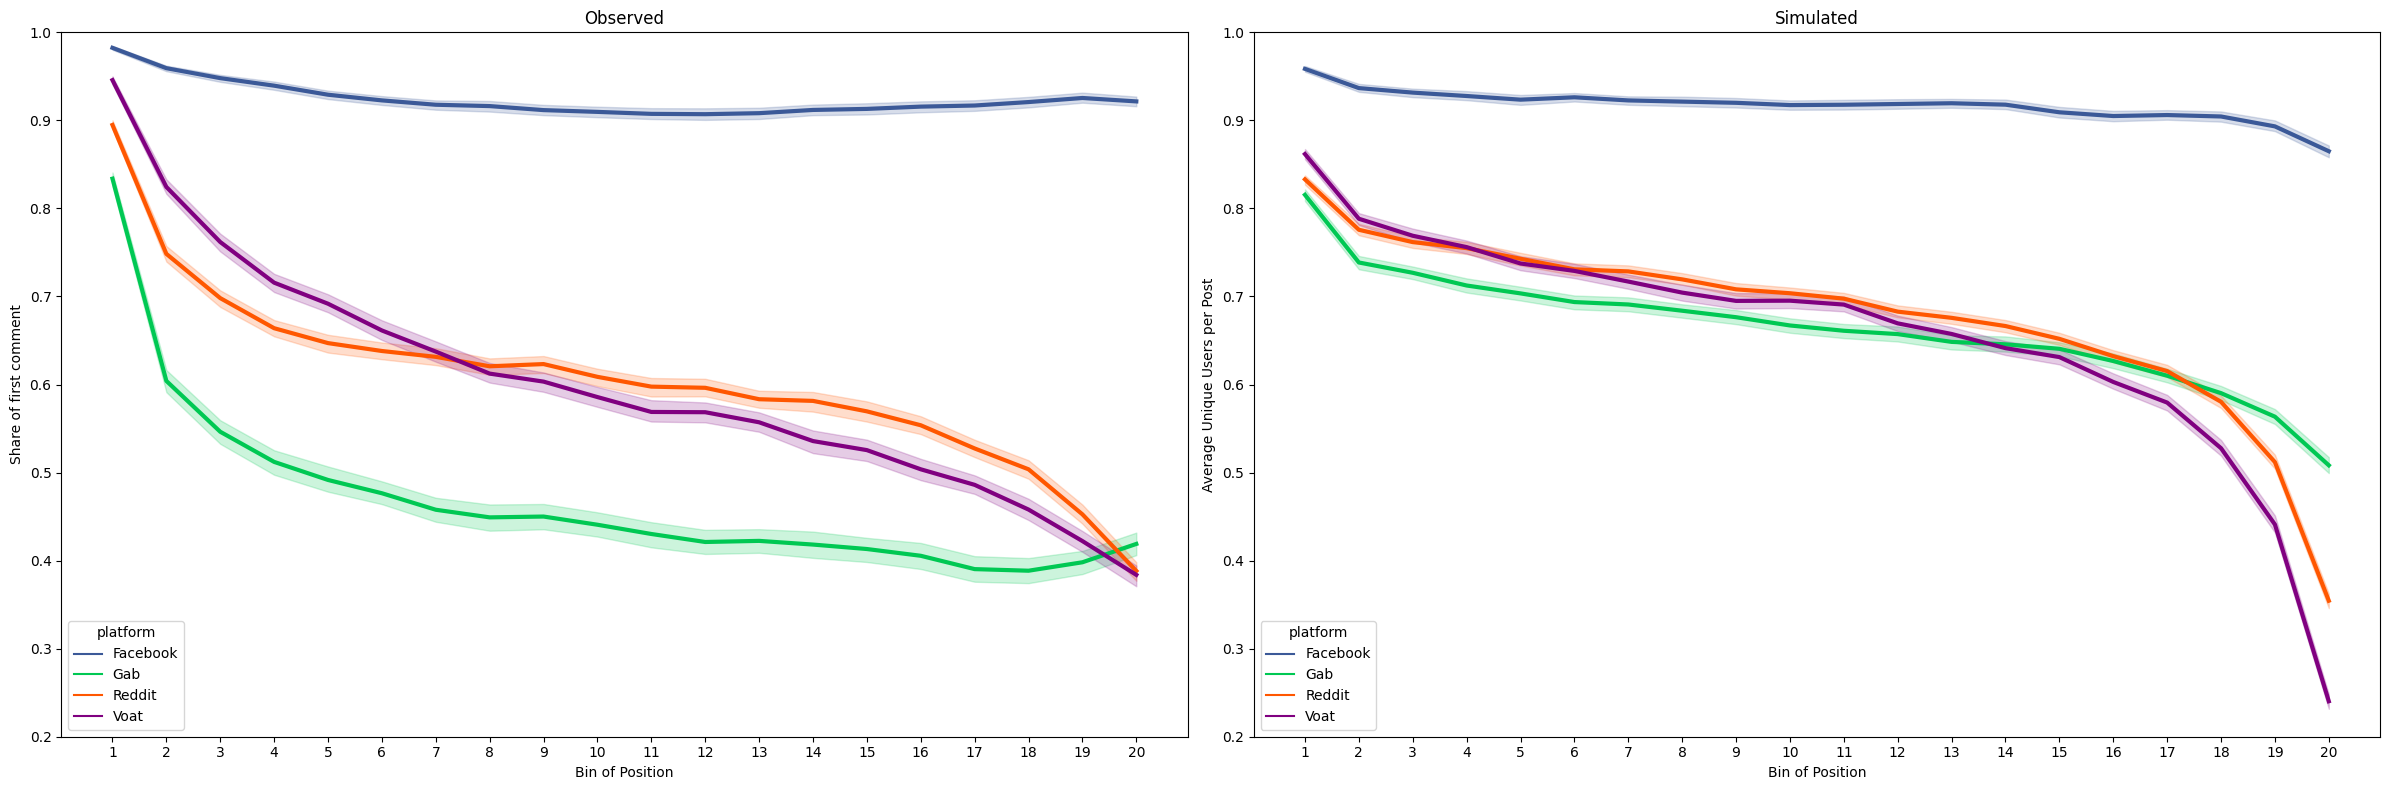

In [96]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Define custom colors
colors = {
    'Reddit': '#FF5700',
    'Voat': '#800080',
    'Facebook': '#3b5998',
    'Gab': '#00c853'
}

# Assuming you have already defined agg_activity_sim_M1 and agg_activity_obs dataframes

# Convert bin_of_position to integer
agg_activity_sim_M1['bin_of_position'] = agg_activity_sim_M1['bin_of_position'].astype(int)
agg_activity_obs['bin_of_position'] = agg_activity_obs['bin_of_position'].astype(int)

# Fit linear regression models
def fit_linear_model(data, platform):
    X = sm.add_constant(data['bin_of_position'])
    y = data['first_comment']
    model = sm.OLS(y, X).fit()
    return model.params[1]  # Return the slope

platforms = ['Reddit', 'Voat', 'Facebook', 'Gab']

# Calculate slopes for each platform in both datasets
slopes_sim = {platform: fit_linear_model(agg_activity_sim_M1[agg_activity_sim_M1['platform'] == platform], platform) for platform in platforms}
slopes_obs = {platform: fit_linear_model(agg_activity_obs[agg_activity_obs['platform'] == platform], platform) for platform in platforms}

# Calculate the differences
differences = {platform: slopes_obs[platform] - slopes_sim[platform] for platform in platforms}

# Create a DataFrame to present the results
results_df = pd.DataFrame({
    'Observed Slope': slopes_obs,
    'Simulated Slope': slopes_sim,
    'Difference': differences
})

print(results_df)

# Plotting
plt.figure(figsize=(24, 8))  # Adjust the figure size as needed

# Subplot for the simulated data
plt.subplot(1, 2, 2)  # 1 row, 2 columns, first plot
sns.lineplot(
    data=agg_activity_sim_M1,
    x='bin_of_position',
    y='first_comment',
    hue='platform',  # Different line for each platform
    estimator='mean',  # Aggregation preference
    errorbar=('ci', 99),  # 80% confidence interval
    linewidth=3,
    palette=colors  # Use custom colors defined in the dictionary
)
plt.title('Simulated')
plt.ylabel('Average Unique Users per Post')
plt.xlabel('Bin of Position')
plt.grid(False)

# Set y-axis limits
plt.ylim(0.2, 1)

# Set x-axis ticks as integers
plt.xticks(agg_activity_sim_M1['bin_of_position'].unique())

# Subplot for the observed data
plt.subplot(1, 2, 1)  # 1 row, 2 columns, second plot
sns.lineplot(
    data=agg_activity_obs,
    x='bin_of_position',
    y='first_comment',
    hue='platform',  # Different line for each platform
    estimator='mean',  # Aggregation preference
    errorbar=('ci', 99),  # 80% confidence interval
    linewidth=3,
    palette=colors  # Use custom colors defined in the dictionary
)
plt.title('Observed')
plt.ylabel('Share of first comment')
plt.xlabel('Bin of Position')
plt.grid(False)

# Set y-axis limits
plt.ylim(0.2, 1)

# Set x-axis ticks as integers
plt.xticks(agg_activity_obs['bin_of_position'].unique())

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
